<table class="ee-notebook-buttons" align="left">
    <td><a target="_blank"  href="https://github.com/NINAnor/urban-treeDetection"><img width=32px src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" style="filter: invert(100%)"/> View source on GitHub</a></td>
    <td><a target="_blank"  href="https://drive.google.com/drive/folders/1mEQBfa-tVViVWFt27XzUP4Wr19u1iuZm"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" /> Run in Google Colab</a></td>
</table>

# Tree Crown Project | Extrapolating Ecosystem Service Values

**Author:** Willeke A'Campo

**Description:** 

This notebook shows the statistical results of extrapolating the regulating ecosystem service values of trees in the Oslo municipality using a Random Forest regression model. The model is trained on the i-Tree Eco trees within Oslo's urban tree database (registerte_traer_BYM_2018) and thereafter used to predict the regulating ecosystem service values for all trees within Oslo's building zone extent.

The following regulating ecosystem services are predicted: 

- carbon storage (kg)
- carbon sequestration (kg/year)
- avoided runoff (m3/year)
- avoided air pollution (g/year)
- total regulating ecosystem benefits (NKr/year)

The predictor variables used in the model are:
- tree species (Norwegian name)
- tree height (m)
- crown area (m2)
- pollution zone (zone 1, 2 or 3)

The results are visualized in a map product, which can be viewed online: [Bytræratlas Oslo](https://experience.arcgis.com/experience/5191adc2c4b34658aea227c9853c6ebb)

In [9]:
# import py-packages
from IPython.display import display, Image, clear_output

import matplotlib.pyplot as plt
import seaborn as sns

# import local packages
from src.config.config import load_catalog, load_parameters
from src.extrapolate_data import *


In [14]:
from src.extrapolation import clean_reference

clean_reference.load_lookup()
df_ref = clean_reference.load_reference()


display(df_ref.head())

{'type': 'csv', 'filepath': 'P:/152022_itree_eco_ifront_synliggjore_trars_rolle_i_okosyst/data/lookup_tables/lookup_oslo_fields.csv', 'filepath_csv': 'P:/152022_itree_eco_ifront_synliggjore_trars_rolle_i_okosyst/data/lookup_tables/lookup_oslo_fields.csv', 'sheet_name': 'oslo_fields'}


,NR,OBJECTID,ID,TREE_ID,CROWN_ID_2014,geo_relation,Bydel,area_code,district_code,suitable_for_itree_spec_dbh,...,runoff_m3_yr,runoff_nok_2023,pollution_co,pollution_o3,pollution_no2,pollution_so2,pollution_pm25,pollution_g_yr,pollution_nok_2023,totben_cap_2023
0,1,1.0,1.0,1.0,103285.0,Case 1,St.hanshaugen,30111.0,3011104.0,1,...,0.1,0.78,0.3,8.4,3.8,0.3,0.4,13.2,8.41,10.51
1,2,2.0,2.0,2.0,8903.0,Case 2,Gamle Oslo,30124.0,3012401.0,1,...,3.5,27.31,72.6,1767.8,783.5,57.9,79.5,2761.3,1758.95,1812.81
2,3,3.0,3.0,3.0,101132.0,Case 1,Gamle Oslo,30124.0,3012401.0,1,...,0.1,0.78,1.6,40.2,17.8,1.3,1.8,62.7,39.94,42.23
3,4,6.0,6.0,6.0,18696.0,Case 2,Vestre Aker,30149.0,3014904.0,1,...,1.5,11.70,8.8,218.0,97.3,7.2,10.1,341.5,217.54,244.68
4,5,7.0,7.0,7.0,101678.0,Case 3,Grünerløkka,30124.0,3012406.0,1,...,0.4,3.12,7.5,182.9,81.1,6.0,8.2,285.7,181.99,196.60


In [10]:
# suprres cell  output
#%%capture --no-display

df_ref, df_target = prepare_data()


{'type': 'csv', 'filepath': 'P:/152022_itree_eco_ifront_synliggjore_trars_rolle_i_okosyst/data/lookup_tables/lookup_oslo_fields.csv', 'filepath_csv': 'P:/152022_itree_eco_ifront_synliggjore_trars_rolle_i_okosyst/data/lookup_tables/lookup_oslo_fields.csv', 'sheet_name': 'oslo_fields'}


AttributeError: 'NoneType' object has no attribute 'columns'

In [30]:
display(df_ref.head())

,tree_id,itree_spec,area_code,district_code,norwegian_name,scientific_name,species_origin,dbh,dbh_origin,height_total_tree,...,SP_hestekastanje,SP_kulelønn,SP_lind,SP_lind_ssp,SP_neverhegg,SP_rosehagtorn,SP_småbladlind,SP_spisslønn,SP_svenskeasal,SP_søylekirsebær
0,itree_1,1,420408,42040804,søylekirsebær,Prunus serrulata ‘Amanogawa’,feltregistrering,7.96,feltregistrering,5.0,...,0,0,0,0,0,0,0,0,0,1
1,itree_2,1,420408,42040804,søylekirsebær,Prunus serrulata ‘Amanogawa’,feltregistrering,12.73,feltregistrering,5.0,...,0,0,0,0,0,0,0,0,0,1
2,itree_3,1,420408,42040804,søylekirsebær,Prunus Serrulata ‘Amanogawa’,feltregistrering,11.46,feltregistrering,5.0,...,0,0,0,0,0,0,0,0,0,1
3,itree_4,1,420408,42040804,søylekirsebær,Prunus serrulata ‘Amanogawa’,feltregistrering,11.46,feltregistrering,5.0,...,0,0,0,0,0,0,0,0,0,1
4,itree_5,1,420408,42040804,bjørk,Betula,feltregistrering,26.69,dbh = 4.04 * height^0.82,10.0,...,0,0,0,0,0,0,0,0,0,0


In [31]:
display(df_target.head())

,id,tree_id,delomradenummer,grunnkretsnummer,norwegian_name,common_name,species_origin,dbh,dbh_origin,height_total_tree,...,SP_kulelønn,SP_lind,SP_lind_ssp,SP_neverhegg,SP_neverhegg?,SP_rosehagtorn,SP_småbladlind,SP_spisslønn,SP_svenskeasal,SP_søylekirsebær
0,1,None,420407.0,42040702.0,alm,None,*Genus estimert basert på treslagfordelingen,2.39,dbh = (crown_diam^2.63)/(3.48^2.63),0.53,...,0,0,0,0,0,0,0,0,0,0
1,2,None,420407.0,42040702.0,kulelønn,None,*Genus estimert basert på treslagfordelingen,43.99,dbh = (crown_diam^2.63)/(3.48^2.63),9.77,...,1,0,0,0,0,0,0,0,0,0
2,3,None,420407.0,42040702.0,kulelønn,None,*Genus estimert basert på treslagfordelingen,17.98,dbh = (crown_diam^2.63)/(3.48^2.63),3.99,...,1,0,0,0,0,0,0,0,0,0
3,4,None,420407.0,42040702.0,kulelønn,None,*Genus estimert basert på treslagfordelingen,27.26,dbh = (crown_diam^2.63)/(3.48^2.63),6.06,...,1,0,0,0,0,0,0,0,0,0
4,5,None,420407.0,42040702.0,kulelønn,None,*Genus estimert basert på treslagfordelingen,7.80,dbh = (crown_diam^2.63)/(3.48^2.63),1.73,...,1,0,0,0,0,0,0,0,0,0


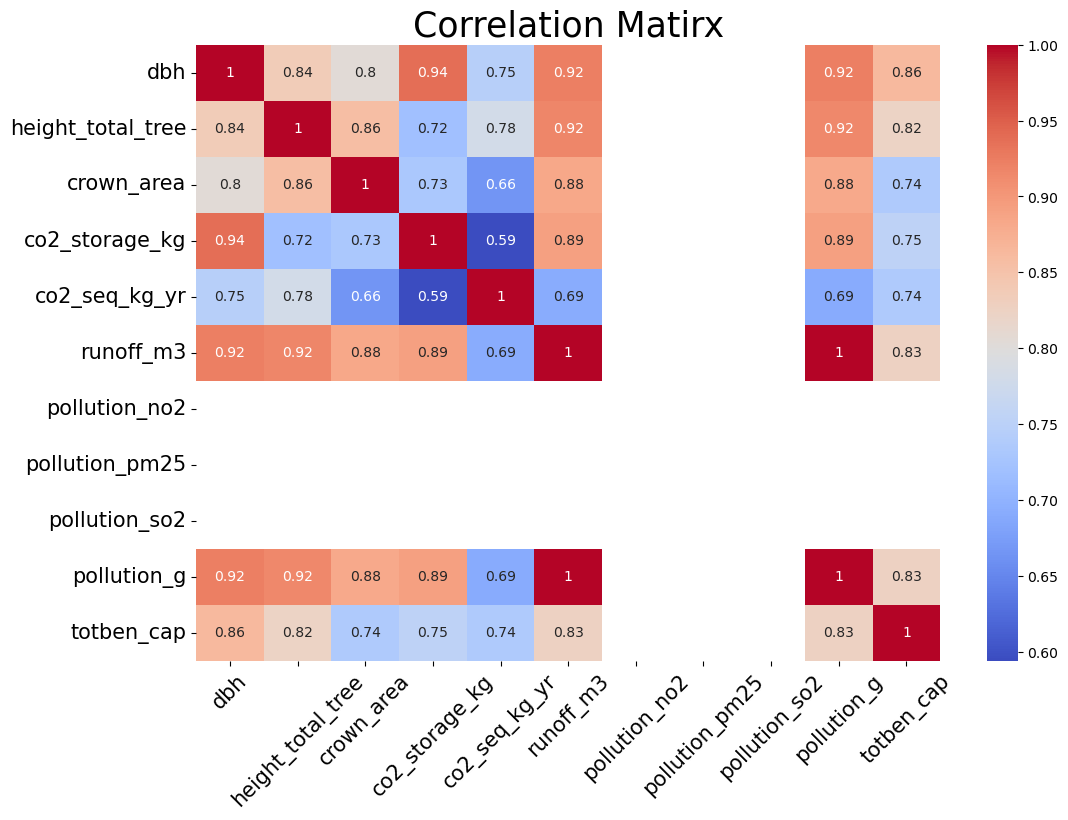

In [35]:
# drop columns with name 'id' and 'genus'
parameters = load_parameters()
cols_float = parameters["cols_float"]

df_corr = df_ref[cols_float]
correlation_matrix = df_corr.corr()

fig, ax = plt.subplots(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm")
ax.set_title("Correlation Matirx", fontweight="ultralight", fontsize=25)
plt.xticks(rotation=45, fontweight="ultralight", fontsize=15)
plt.yticks(fontsize=15)
plt.show()

2023-12-17 21:26:28 src.extrapolation.regressor [INFO]: Split data into training and test sets...
2023-12-17 21:26:28 src.extrapolation.regressor [INFO]: PREDICTORS: ['dbh', 'height_total_tree', 'crown_area', 'pollution_zone', 'SP_alm', 'SP_bjørk', 'SP_blodbøk', 'SP_bøk', 'SP_hestekastanje', 'SP_kulelønn', 'SP_lind', 'SP_lind_ssp', 'SP_neverhegg', 'SP_rosehagtorn', 'SP_småbladlind', 'SP_spisslønn', 'SP_svenskeasal', 'SP_søylekirsebær']
2023-12-17 21:26:28 src.extrapolation.regressor [INFO]: RESPONSE: ['totben_cap']
2023-12-17 21:26:28 src.extrapolation.regressor [INFO]: Y_train shape: (64,)
2023-12-17 21:26:28 src.extrapolation.regressor [INFO]: y_test shape: (16,)
kristiansand_totben_cap
2023-12-17 21:26:29 src.extrapolation.regressor [INFO]: Evaluate model performance on test data...
2023-12-17 21:26:29 src.extrapolation.regressor [INFO]: Model equation: y = 0.4 + 3.1*dbh + 8.4*height_total_tree + 0.1*crown_area + -1.4*pollution_zone + ...
2023-12-17 21:26:29 src.extrapolation.regres

<Figure size 640x480 with 0 Axes>

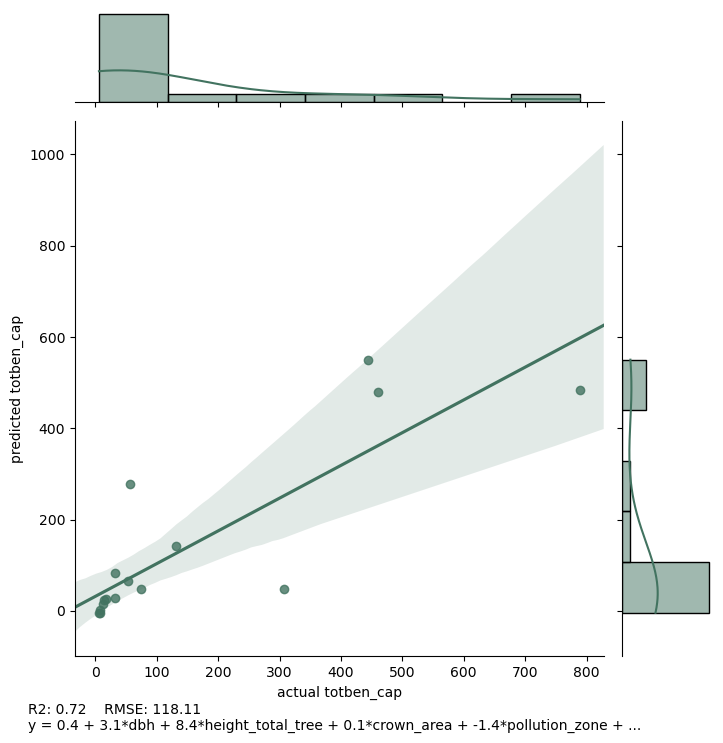

In [36]:
totben_cap(df_ref, df_target)

In [ ]:
individual_es(df_ref, df_target)

In [ ]:
carbon_es(df_ref, df_target)

In [ ]:
export_results()

In [ ]:
summary_stat()